# Model-Based Reinforcement Learning

## Principle
We consider the optimal control problem of an MDP with a **known** reward function $R$ and subject to **unknown deterministic** dynamics $s_{t+1} = f(s_t, a_t)$:

$$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t R(s_t,a_t)$$

In **model-based reinforcement learning**, this problem is solved in **two steps**:
1. **Model learning**:
We learn a model of the dynamics $f_\theta \simeq f$ through regression on interaction data.
2. **Planning**:
We leverage the dynamics model $f_\theta$ to compute the optimal trajectory $$\max_{(a_0,a_1,\dotsc)} \sum_{t=0}^\infty \gamma^t R(\hat{s}_t,a_t)$$ following the learnt dynamics $\hat{s}_{t+1} = f_\theta(\hat{s}_t, a_t)$.

(We can easily extend to unknown rewards and stochastic dynamics, but we consider the simpler case in this notebook for ease of presentation)


## Motivation

### Sparse rewards
* In model-free reinforcement learning, we only obtain a reinforcement signal when encountering rewards. In environment with **sparse rewards**, the chance of obtaining a reward randomly is **negligible**, which prevents any learning.
* However, even in the **absence of rewards** we still receive a **stream of state transition data**. We can exploit this data to learn about the task at hand.

### Complexity of the policy/value vs dynamics:
Is it easier to decide which action is best, or to predict what is going to happen?
* Some problems can have **complex dynamics** but a **simple optimal policy or value function**. For instance, consider the problem of learning to swim. Predicting the movement requires understanding fluid dynamics and vortices while the optimal policy simply consists in moving the limbs in sync.
* Conversely, other problems can have **simple dynamics** but **complex policies/value functions**. Think of the game of Go, its rules are simplistic (placing a stone merely changes the board state at this location) but the corresponding optimal policy is very complicated.

Intuitively, model-free RL should be applied to the first category of problems and model-based RL to the second category.

### Inductive bias
Oftentimes, real-world problems exhibit a particular **structure**: for instance, any problem involving motion of physical objects will be **continuous**. It can also be **smooth**, **invariant** to translations, etc. This knowledge can then be incorporated in machine learning models to foster efficient learning. In contrast, there can often be **discontinuities** in the policy decisions or value function: e.g. think of a collision vs near-collision state.

###  Sample efficiency
Overall, it is generally recognized that model-based approaches tend to **learn faster** than model-free techniques (see e.g. [[Sutton, 1990]](http://papersdb.cs.ualberta.ca/~papersdb/uploaded_files/paper_p160-sutton.pdf.stjohn)).

### Interpretability
In real-world applications, we may want to know **how a policy will behave before actually executing it**, for instance for **safety-check** purposes. However, model-free reinforcement learning only recommends which action to take at current time without being able to predict its consequences. In order to obtain the trajectory, we have no choice but executing the policy. In stark contrast, model-based methods a more interpretable in the sense that we can probe the policy for its intended (and predicted) trajectory.

## Our challenge: Automated Parking System

We consider the **parking-parallel-v0** task of the [highway-env](https://github.com/eleurent/highway-env) environment. It is a **goal-conditioned continuous control** task where an agent **drives a car** by controlling the gaz pedal and steering angle and must **park in a given location** with the appropriate heading.

This MDP has several properties which justifies using model-based methods:
* The policy/value is highly dependent on the goal which adds a significant level of complexity to a model-free learning process, whereas the dynamics are completely independent of the goal and hence can be simpler to learn.
* In the context of an industrial application, we can reasonably expect for safety concerns that the planned trajectory is required to be known in advance, before execution.

###  Warming up
We start with a few useful installs and imports:

We also define a simple helper function for visualization of episodes:

In [1]:
print('Hi')

Hi


In [2]:
# Install environment and visualization dependencies 
# !pip install highway-env

# Environment
# Force reload highway_env module
import sys
import importlib

# Remove all highway_env related modules from cache
modules_to_remove = [key for key in sys.modules.keys() if 'highway_env' in key]
for module in modules_to_remove:
    del sys.modules[module]
    
print(f"🔄 Cleared {len(modules_to_remove)} cached modules")

# Now import fresh
import highway_env
import gymnasium as gym

print("✅ Fresh import complete!")

gym.register_envs(highway_env)

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple

# Visualization
import matplotlib.pyplot as plt
import copy
%matplotlib inline

# deleting old videos
import shutil
import os

folder_path = r"/home/aayush_wsl/cs269_rl_parking/CS269-Parking/videos"
folder_path2 = r"/home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts/videos"
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Video Folder deleted.")
else:
    print("Video Folder does not exist.")

if os.path.exists(folder_path2):
    shutil.rmtree(folder_path2)
    print("Video Folder deleted.")
else:
    print("Video Folder does not exist.")

🔄 Cleared 1 cached modules
✅ Fresh import complete!
Video Folder does not exist.
Video Folder deleted.


In [3]:
import sys
from tqdm.notebook import trange
from tqdm import trange
# !pip install tensorboardx gym pyvirtualdisplay
# !apt-get install -y xvfb ffmpeg
# !git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/Users/anmol/githubRepos/CS269-Parking/scripts')
from utils import record_videos, show_videos

In [4]:
# Verify import location
print("🔍 Importing from:", highway_env.__file__)
print()

# Create environment WITHOUT passing config
env = gym.make("parking-parallel-dynObs-v0")
config = env.unwrapped.config

# Check the configuration
print("📋 Current Default Configuration:")
print(f"  Duration: {config['duration']}")
print(f"  Policy frequency: {config['policy_frequency']}")
print(f"  Vehicles count: {config['vehicles_count']}")
print(f"  Steering range: {config['steering_range']}")
print(f"  Reward weights: {config['reward_weights']}")
print(f"  Success goal reward: {config['success_goal_reward']}")

env.close()

🔍 Importing from: /home/aayush_wsl/cs269_rl_parking/CS269-Parking/highway_env/__init__.py

📋 Current Default Configuration:
  Duration: 100
  Policy frequency: 5
  Vehicles count: 11
  Steering range: 1.0471975511965976
  Reward weights: [1, 1, 0.1, 0.1, 1, 1]
  Success goal reward: 0.12


### Let's try it!

Make the environment, and run an episode with random actions:

In [5]:
# Full configuration dictionary for parking-parallel-v0 environment
parking_config = {
    # Observation configuration
    "observation": {
        "type": "KinematicsGoal",
        "features": ["x", "y", "vx", "vy", "cos_h", "sin_h"],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False,
    },
    
    # Action configuration
    "action": {
        "type": "ContinuousAction",
        # "acceleration_range": (-1, 1),
        # "speed_range": (-1.5, 1.5),
    },
    
    # Reward parameters
    "reward_weights": [1, 1, 0.1, 0.1, 1, 1],  # Weights for [x, y, vx, vy, cos_h, sin_h]
    "success_goal_reward": 0.12,
    "collision_reward": -5,
    
    # Vehicle control parameters
    "steering_range": np.deg2rad(60),  # Maximum steering angle in radians
    
    # Simulation parameters
    "simulation_frequency": 15,  # Hz
    "policy_frequency": 5,       # Hz
    "duration": 200,             # Maximum episode duration in steps
    
    # Rendering parameters
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": True,
    
    # Environment setup
    "controlled_vehicles": 1,    # Number of vehicles to control
    "vehicles_count": 9,         # Number of parked vehicles (obstacles)
    "add_walls": True,           # Whether to add boundary walls

    # Additional parameters from AbstractEnv
    "offscreen_rendering": False,
    "manual_control": False,
    "real_time_rendering": False,
}

In [6]:
env = gym.make("parking-parallel-dynObs-v0", render_mode="rgb_array", config=parking_config)

config = env.unwrapped.config

print("=" * 80)
print("🚗 PARKING ENVIRONMENT CONFIGURATION")
print("=" * 80)

print("\n📊 OBSERVATION SETTINGS:")
print(f"  Type: {config['observation']['type']}")
print(f"  Features: {config['observation']['features']}")
print(f"  Scales: {config['observation']['scales']}")
print(f"  Normalize: {config['observation']['normalize']}")

print("\n🎮 ACTION SETTINGS:")
print(f"  Type: {config['action']['type']}")
# print(f"  Acceleration range: {config['action']['acceleration_range']}")
# print(f"  Speed range: {config['action']['speed_range']}")
# print(f"  Steering range: {config['steering_range']:.4f} rad ({np.rad2deg(config['steering_range']):.1f}°)")

print("\n🎯 REWARD SETTINGS:")
print(f"  Reward weights [x, y, vx, vy, cos_h, sin_h]: {config['reward_weights']}")
print(f"  Success goal threshold: {config['success_goal_reward']}")
print(f"  Collision penalty: {config['collision_reward']}")

print("\n⏱️ SIMULATION SETTINGS:")
print(f"  Simulation frequency: {config['simulation_frequency']} Hz")
print(f"  Policy frequency: {config['policy_frequency']} Hz")
print(f"  Max episode duration: {config['duration']} steps")
print(f"  Real-time duration: {config['duration'] / config['policy_frequency']:.1f} seconds")

print("\n🎨 RENDERING SETTINGS:")
print(f"  Screen size: {config['screen_width']}x{config['screen_height']}")
print(f"  Centering position: {config['centering_position']}")
print(f"  Scaling: {config['scaling']}")

print("\n🚙 ENVIRONMENT SETUP:")
print(f"  Controlled vehicles: {config['controlled_vehicles']}")
print(f"  Parked vehicles (obstacles): {config['vehicles_count']}")
print(f"  Boundary walls: {config['add_walls']}")

print("\n" + "=" * 80)

🚗 PARKING ENVIRONMENT CONFIGURATION

📊 OBSERVATION SETTINGS:
  Type: KinematicsGoal
  Features: ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']
  Scales: [100, 100, 5, 5, 1, 1]
  Normalize: False

🎮 ACTION SETTINGS:
  Type: ContinuousAction

🎯 REWARD SETTINGS:
  Reward weights [x, y, vx, vy, cos_h, sin_h]: [1, 1, 0.1, 0.1, 1, 1]
  Success goal threshold: 0.12
  Collision penalty: -5

⏱️ SIMULATION SETTINGS:
  Simulation frequency: 15 Hz
  Policy frequency: 5 Hz
  Max episode duration: 200 steps
  Real-time duration: 40.0 seconds

🎨 RENDERING SETTINGS:
  Screen size: 600x300
  Centering position: [0.5, 0.5]
  Scaling: 7

🚙 ENVIRONMENT SETUP:
  Controlled vehicles: 1
  Parked vehicles (obstacles): 9
  Boundary walls: True



In [7]:
env = gym.make("parking-parallel-dynObs-v0", render_mode="rgb_array", config=parking_config)
env = record_videos(env)
env.reset()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

The environment is a `GoalEnv`, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy.

In [8]:
print("Observation format:", obs)

Observation format: OrderedDict([('observation', array([-0.00239784,  0.08783215, -0.36019228,  0.88824775,  0.3757874 ,
       -0.9267059 ])), ('achieved_goal', array([-0.00239784,  0.08783215, -0.36019228,  0.88824775,  0.3757874 ,
       -0.9267059 ])), ('desired_goal', array([-0.14, -0.12,  0.  ,  0.  ,  1.  ,  0.  ]))])


There is also an `achieved_goal` that won't be useful here (it only serves when the state and goal spaces are different, as a projection from the observation to the goal space).

Alright! We are now ready to apply the model-based reinforcement learning paradigm.

## Experience collection
First, we randomly interact with the environment to produce a batch of experiences 

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [9]:
# # Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

# # def collect_interaction_data(env, size=5000, action_repeat=1):
# #     data, done = [], True
# #     for _ in trange(size, desc="Collecting interaction data"):
# #         action = env.action_space.sample()
# #         for _ in range(action_repeat):
# #             if done:
# #               previous_obs, info = env.reset()
# #             obs, reward, done, truncated, info = env.step(action)
# #             data.append(Transition(torch.Tensor(previous_obs["observation"]),
# #                                    torch.Tensor(action),
# #                                    torch.Tensor(obs["observation"])))
# #             previous_obs = obs
# #     return data

# Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

# def collect_interaction_data(env, size=10000, action_repeat=1):
#     data, done = [], True
#     episode_count = 0
#     episode_lengths = []
#     current_episode_length = 0
    
#     for _ in trange(size, desc="Collecting interaction data"):
#         action = env.action_space.sample()
#         for _ in range(action_repeat):
#             if done:
#                 if episode_count > 0:
#                     episode_lengths.append(current_episode_length)
#                 previous_obs, info = env.reset()
#                 episode_count += 1
#                 current_episode_length = 0
                
#             obs, reward, done, truncated, info = env.step(action)
#             current_episode_length += 1
#             data.append(Transition(torch.Tensor(previous_obs["observation"]),
#                                    torch.Tensor(action),
#                                    torch.Tensor(obs["observation"])))
#             previous_obs = obs
#             done = done or truncated  # Combine done flags
    
#     # Print statistics
#     print(f"\n📊 Collection Statistics:")
#     print(f"  Total transitions: {len(data)}")
#     print(f"  Number of episodes: {episode_count}")
#     print(f"  Average episode length: {np.mean(episode_lengths):.1f} steps")
#     print(f"  Min/Max episode length: {min(episode_lengths)}/{max(episode_lengths)} steps")
    
#     return data

# env = gym.make("parking-parallel-v0", render_mode="rgb_array", config=parking_config)
# print(env.unwrapped.config['action'])
# print(env.unwrapped.config)
# data = collect_interaction_data(env)
# print("Sample transition:", data[0])

In [10]:
# # Save data in a pickle file within the scripts folder with a data time stamp
# import pickle
# import datetime

# # Get current date and time as a string
# data_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# # Define the filename with the timestamp
# filename = f"interaction_data_{data_timestamp}.pkl" 

# # Save the data to the file
# with open(filename, 'wb') as f:
#     pickle.dump(data, f)

## Build a dynamics model

We now design a model to represent the system dynamics. We choose  a **structured model** inspired from *Linear Time-Invariant (LTI) systems* 

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

where the $(x, u)$ notation comes from the Control Theory community and stands for the state and action $(s,a)$. Intuitively, we learn at each point $(x_t, u_t)$ the **linearization** of the true dynamics $f$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [11]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt

## Fit the model on data
We can now train our model $f_\theta$ in a supervised fashion to minimize an MSE loss $L^2(f_\theta; D)$ over our experience batch $D$ by stochastic gradient descent:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t)||^2$$

In [12]:
# # ===== DATA SPLIT =====
# # Load data from the pickle file
# import pickle
# filename = r'/home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts/interaction_data_20251128_034835.pkl'
# with open(filename, 'rb') as f:
#     data = pickle.load(f)

# dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
#                          action_size=env.action_space.shape[0],
#                          hidden_size=96,  # Reduced from 96
#                          dt=1/env.unwrapped.config["policy_frequency"]
#                          ) 
# print("Forward initial model on a sample transition:",
#       dynamics(data[0].state.unsqueeze(0), data[0].action.unsqueeze(0)).detach())

# #optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)
# # ===== OPTIMIZER & SCHEDULER =====
# optimizer = torch.optim.Adam(
#     dynamics.parameters(), 
#     lr=0.005,              # Reduced from 0.01 (↓50%)
#     weight_decay=1e-5      # L2 regularization to prevent overfitting
# )

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,            # Halve LR when plateau
#     patience=50,           # Wait 50 epochs
#     min_lr=1e-5,           # Don't go below this
# )

# # Split dataset into training and validation
# # # train_ratio = 0.7
# # train_data, validation_data = data[:int(train_ratio * len(data))], data[int(train_ratio * len(data)):]
# train_ratio = 0.7         # Increased from 0.7 (more training data)
# train_data = data[:int(train_ratio * len(data))]      # 4000 samples
# validation_data = data[int(train_ratio * len(data)):] # 1000 samples

# def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
#     states, actions, next_states = data_t
#     predictions = model(states, actions)
#     return loss_func(predictions, next_states)

# def transpose_batch(batch):
#     return Transition(*map(torch.stack, zip(*batch)))

# # ===== TRAINING SETTINGS =====
# early_stopping_patience = 80
# def train(model, train_data, validation_data, epochs=1500):
#     train_data_t = transpose_batch(train_data)
#     validation_data_t = transpose_batch(validation_data)
#     losses = []

#     # ===== New code =====
#     best_val_loss = float('inf') 
#     epochs_no_improve = 0
#     best_model_state = None

#     for epoch in trange(epochs, desc="Train dynamics"):
#         # Forward pass
#         loss = compute_loss(model, train_data_t)
#         validation_loss = compute_loss(model, validation_data_t)
        
#         # Store losses
#         losses.append([loss.item(), validation_loss.item()])
        
#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
        
#         # Gradient clipping (prevents exploding gradients)
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
#         optimizer.step()
        
#         # Update learning rate based on validation loss
#         scheduler.step(validation_loss)
        
#         # Early stopping check
#         if validation_loss < best_val_loss:
#             best_val_loss = validation_loss
#             epochs_no_improve = 0
#             best_model_state = copy.deepcopy(model.state_dict())
#         else:
#             epochs_no_improve += 1
        
#         if epochs_no_improve >= early_stopping_patience:
#             print(f"\nEarly stopping at epoch {epoch}")
#             print(f"Best validation loss: {best_val_loss:.6f}")
#             model.load_state_dict(best_model_state)
#             break
        
#         # Print progress every 100 epochs
#         if (epoch + 1) % 100 == 0:
#             current_lr = optimizer.param_groups[0]['lr']
#             print(f"\nEpoch {epoch+1}: train={loss.item():.6f}, "
#                   f"val={validation_loss.item():.6f}, lr={current_lr:.6f}")
    
#     # Plot losses
#     losses = np.array(losses)
#     plt.figure(figsize=(10, 5))
#     plt.plot(losses[:, 0], label='train', alpha=0.8)
#     plt.plot(losses[:, 1], label='validation', alpha=0.8)
#     plt.yscale("log")
#     plt.xlabel("epochs")
#     plt.ylabel("loss (MSE)")
#     plt.title("Training Progress")
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.show()
    
#     return losses

# # Train the model
# losses = train(dynamics, train_data, validation_data, epochs=600)
#     # ===== End of new code =====

# # ==== Legacy code =====
# #     for epoch in trange(epochs, desc="Train dynamics"):
# #         # Compute loss gradient and step optimizer
# #         loss = compute_loss(model, train_data_t)
# #         validation_loss = compute_loss(model, validation_data_t)
# #         losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()
# #     # Plot losses
# #     plt.plot(losses)
# #     plt.yscale("log")
# #     plt.xlabel("epochs")
# #     plt.ylabel("loss")
# #     plt.legend(["train", "validation"])
# #     plt.show()

# # train(dynamics, data, validation_data)
# # ==== End of legacy code =====

## Visualize trained dynamics

In order to qualitatively evaluate our model, we can choose some values of steering angle *(right, center, left)* and acceleration *(slow, fast)* in order to predict and visualize the corresponding trajectories from an initial state.  


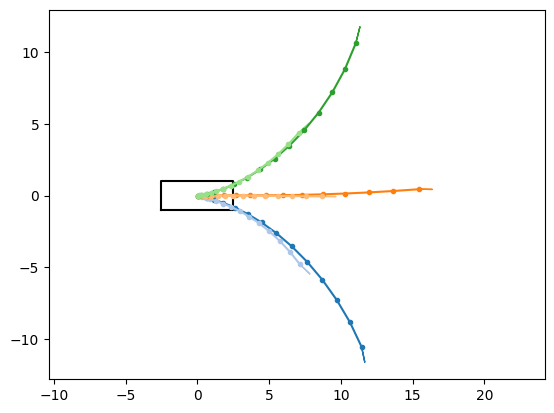

In [13]:
#import the best dynamics model
import pickle
filename = r'/home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts/dynamics_model_20251128_050826_best.pkl'
with open(filename, 'rb') as f:
    dynamics = pickle.load(f)

def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()
    
visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

## Reward model
We assume that the reward $R(s,a)$ is known (chosen by the system designer), and takes the form of a **weighted L1-norm** between the state and the goal.

In [14]:
def reward_model(states, goal, gamma=None, terminal_weight=1.0):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)

    # NEW: Apply extra weight to terminal state (last timestep)
    if terminal_weight != 1.0:
        terminal_mask = torch.zeros_like(rewards)
        terminal_mask[-1] = terminal_weight - 1.0  # Extra weight on last timestep
        rewards = rewards * (1.0 + terminal_mask)
    
    return rewards

obs, info = env.reset()
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"])))

Reward of a sample transition: tensor([-1.0497])


## Leverage dynamics model for planning

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

This method approximates the optimal importance sampling estimator by repeating two phases:
1. **Draw samples** from a probability distribution. We use Gaussian distributions over sequences of actions.
2. Minimize the **cross-entropy** between this distribution and a **target distribution** to produce a better sample in the next iteration. We define this target distribution by selecting the top-k performing sampled sequences.

![Credits to Olivier Sigaud](https://github.com/yfletberliac/rlss2019-hands-on/blob/master/imgs/cem.png?raw=1)

Note that as we have a local linear dynamics model, we could instead choose an `Iterative LQR` planner which would be more efficient. We prefer `CEM` in this educational setting for its simplicity and generality.

In [15]:
# def cem_planner(state, goal, action_size, horizon=12, population=200, selection=20, iterations=8):
#     state = state.expand(population, -1)
#     action_mean = torch.zeros(horizon, 1, action_size)
#     action_std = torch.ones(horizon, 1, action_size)
#     for _ in range(iterations):
#         # 1. Draw sample sequences of actions from a normal distribution
#         actions = torch.normal(mean=action_mean.repeat(1, population, 1), std=action_std.repeat(1, population, 1))
#         actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
#         states = predict_trajectory(state, actions, dynamics, action_repeat=1)
#         # 2. Fit the distribution to the top-k performing sequences
#         returns = reward_model(states, goal, gamma=None, terminal_weight = 2.5).sum(dim=0)
#         _, best = returns.topk(selection, largest=True, sorted=False)
#         best_actions = actions[:, best, :]
#         action_mean = best_actions.mean(dim=1, keepdim=True)
#         action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
#     return action_mean[0].squeeze(dim=0)
  
# print(torch.Tensor(obs['desired_goal'])) 
# # Run the planner on a sample transition
# action = cem_planner(torch.Tensor(obs["observation"]),
#                      torch.Tensor(obs["desired_goal"]),
#                      env.action_space.shape[0])
# print("Planned action:", action)

# # Implementing Model Predictive Control with the dynamics model trained above to successfully do parallel parking



# MPC implementation

In [16]:
def get_obstacle_info(env):
    """
    Extract ALL obstacles: static vehicles, dynamic vehicles, and walls.
    
    Returns:
        obstacles: List of dicts with 'position', 'heading', 'dimensions', 'type'
    """
    obstacles = []
    
    # Use the new environment method
    if hasattr(env.unwrapped, 'get_all_obstacles_info'):
        obstacles_info = env.unwrapped.get_all_obstacles_info()
        
        # Combine all obstacle types into a single list
        for static_veh in obstacles_info['static_vehicles']:
            obstacles.append({
                'position': static_veh['position'],
                'heading': static_veh['heading'],
                'length': static_veh['length'],
                'width': static_veh['width'],
                'type': 'static_vehicle'
            })
        
        for dyn_veh in obstacles_info['dynamic_vehicles']:
            obstacles.append({
                'position': dyn_veh['position'],
                'heading': dyn_veh['heading'],
                'length': dyn_veh['length'],
                'width': dyn_veh['width'],
                'type': 'dynamic_vehicle'
            })
        
        for wall in obstacles_info['walls']:
            obstacles.append({
                'position': wall['position'],
                'heading': wall['heading'],
                'length': wall['length'],
                'width': wall['width'],
                'type': 'wall'
            })
    
    else:
        # Fallback: old method (only static vehicles)
        print("⚠️ Warning: Environment doesn't have get_all_obstacles_info(). Using fallback.")
        if hasattr(env.unwrapped, 'road') and env.unwrapped.road:
            vehicles = env.unwrapped.road.vehicles[1:]
            for vehicle in vehicles:
                obstacles.append({
                    'position': np.array([vehicle.position[0], vehicle.position[1]]),
                    'heading': vehicle.heading,
                    'length': vehicle.LENGTH,
                    'width': vehicle.WIDTH,
                    'type': 'static_vehicle'
                })
    
    return obstacles

def predict_dynamic_obstacle_positions(obstacles, horizon, dt=0.2):
    """
    Predict future positions of dynamic obstacles.
    
    Args:
        obstacles: List of obstacle dicts
        horizon: Planning horizon
        dt: Time step (policy_frequency = 5Hz → dt = 0.2s)
    
    Returns:
        predicted_obstacles: List of lists, where predicted_obstacles[t] 
                            contains all obstacle positions at timestep t
    """
    predicted_obstacles = []
    
    for t in range(horizon + 1):
        time = t * dt
        timestep_obstacles = []
        
        for obs in obstacles:
            obs_copy = obs.copy()
            
            # Only predict for dynamic obstacles
            if obs.get('type') == 'dynamic_vehicle' and obs.get('speed', 0) > 0.1:
                # Simple linear prediction: pos_future = pos_now + velocity * time
                heading = obs['heading']
                speed = obs.get('speed', 0)
                
                # Velocity components
                vx = speed * np.cos(heading)
                vy = speed * np.sin(heading)
                
                # Predicted position
                predicted_x = obs['position'][0] + vx * time
                predicted_y = obs['position'][1] + vy * time
                
                obs_copy['position'] = np.array([predicted_x, predicted_y])
            
            timestep_obstacles.append(obs_copy)
        
        predicted_obstacles.append(timestep_obstacles)
    
    return predicted_obstacles


def compute_collision_cost_temporal(states, obstacles_trajectory, ego_length=5.0, 
                                    ego_width=2.0, safety_margin=0.5, device='cpu'):
    """
    Collision cost with time-varying obstacle positions.
    
    Args:
        states: [horizon+1, state_size]
        obstacles_trajectory: List of length (horizon+1), each element is 
                             a list of obstacles at that timestep
    """
    if len(obstacles_trajectory) == 0 or len(obstacles_trajectory[0]) == 0:
        return torch.tensor(0.0, device=device)
    
    scales = torch.tensor([100.0, 100.0, 5.0, 5.0, 1.0, 1.0], 
                         dtype=torch.float32, device=device)
    
    ego_x = states[:, 0] * scales[0]  # [horizon+1]
    ego_y = states[:, 1] * scales[1]  # [horizon+1]
    
    total_cost = torch.tensor(0.0, device=device)
    
    # Iterate over time steps
    for t in range(len(obstacles_trajectory)):
        if t >= len(ego_x):
            break
            
        obstacles_t = obstacles_trajectory[t]
        ego_x_t = ego_x[t]
        ego_y_t = ego_y[t]
        
        # Compute collision cost for this timestep
        for obs in obstacles_t:
            obs_x, obs_y = obs['position']
            obs_length = obs['length']
            obs_width = obs['width']
            obs_type = obs.get('type', 'unknown')
            
            # Adaptive margin (same as before)
            if obs_type == 'wall':
                adaptive_margin = 1.5
                weight = 200.0
                sharpness = 3.0
            elif obs_type == 'dynamic_vehicle':
                adaptive_margin = 2.0
                weight = 150.0
                sharpness = 2.5
            else:
                adaptive_margin = 0.8
                weight = 100.0
                sharpness = 2.0
            
            # Distance at this timestep
            dx = torch.abs(ego_x_t - obs_x)
            dy = torch.abs(ego_y_t - obs_y)
            distance = torch.sqrt(dx**2 + dy**2 + 1e-6)
            
            # Safe distance
            ego_radius = np.sqrt((ego_length/2)**2 + (ego_width/2)**2)
            obs_radius = np.sqrt((obs_length/2)**2 + (obs_width/2)**2)
            safe_distance = ego_radius + obs_radius + adaptive_margin
            
            # Exponential barrier
            penetration = safe_distance - distance
            collision_penalty = weight * (torch.exp(sharpness * torch.relu(penetration)) - 1.0)
            
            total_cost += collision_penalty
    
    return total_cost

In [17]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np

def mpc_planner(
    state, 
    goal, 
    action_size, 
    dynamics_model,
    horizon=12,
    num_iterations=50,
    learning_rate=0.1,
    action_repeat=1,
    terminal_weight=2.5,
    obstacles=None,           # ✅ NEW: List of obstacles
    collision_weight=50.0,    # ✅ NEW: Collision penalty weight
    verbose=False
):
    """
    Model Predictive Control planner using gradient-based optimization.
    
    Args:
        state: Current state tensor [state_size]
        goal: Goal state tensor [state_size]
        action_size: Dimension of action space (2: acceleration, steering)
        dynamics_model: Trained neural network dynamics model
        horizon: Planning horizon (number of timesteps)
        num_iterations: Number of optimization iterations
        learning_rate: Learning rate for Adam optimizer
        action_repeat: Number of times each action is repeated
        terminal_weight: Extra weight on terminal state cost
        verbose: Print optimization progress
    
    Returns:
        Optimized first action [action_size]
    """
    device = state.device

    # ===== ✅ NEW: Predict dynamic obstacle trajectories =====
    if obstacles is not None:
        dt = 1.0 / env.unwrapped.config["policy_frequency"]  # 0.2s per step
        obstacles_trajectory = predict_dynamic_obstacle_positions(obstacles, horizon, dt)
    else:
        obstacles_trajectory = []
    
    # ===== STEP 1: Initialize action sequence =====
    # Start with small random actions near zero (warm start)
    action_sequence = torch.randn(
        horizon, action_size, 
        device=device
    ) * 0.1
    action_sequence.requires_grad_(True) 
    # ===== STEP 2: Setup optimizer =====
    optimizer = Adam([action_sequence], lr=learning_rate)
    
    # Action bounds from environment
    action_min = torch.tensor(
        env.action_space.low, 
        device=device, 
        dtype=torch.float32
    )
    action_max = torch.tensor(
        env.action_space.high, 
        device=device, 
        dtype=torch.float32
    )
    
    best_cost = float('inf')
    best_action_sequence = None
    
    # ===== STEP 3: Optimization loop =====
    for iteration in range(num_iterations):
        optimizer.zero_grad()
        
        # Clamp actions to valid range
        with torch.no_grad():
            action_sequence.data = torch.clamp(
                action_sequence.data, 
                action_min, 
                action_max
            )
        
        # ===== STEP 4: Predict trajectory using dynamics model =====
        current_state = state.unsqueeze(0)  # [1, state_size]
        predicted_states = [current_state]
        
        for t in range(horizon):
            action_t = action_sequence[t].unsqueeze(0)  # [1, action_size]
            
            # Predict next state using learned dynamics
            next_state = dynamics_model(current_state, action_t)
            predicted_states.append(next_state)
            current_state = next_state
        
        # Stack all predicted states [horizon+1, state_size]
        predicted_states = torch.cat(predicted_states, dim=0)
        
        # ===== STEP 5: Compute cost function =====
        cost = compute_mpc_cost(
                predicted_states,
                goal,
                action_sequence,
                terminal_weight=terminal_weight,
                obstacles_trajectory=obstacles_trajectory,  # ✅ CHANGED
                collision_weight=collision_weight  # ✅ PASS WEIGHT
                )
        
        # Track best solution
        if cost.item() < best_cost:
            best_cost = cost.item()
            best_action_sequence = action_sequence.data.clone()
        
        # ===== STEP 6: Backpropagation and optimization step =====
        cost.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_([action_sequence], max_norm=1.0)
        
        optimizer.step()
        
        if verbose and (iteration % 10 == 0 or iteration == num_iterations - 1):
            print(f"Iteration {iteration:3d}: Cost = {cost.item():.6f}")
    
    # ===== STEP 7: Return first action from best sequence =====
    return best_action_sequence[0]


def compute_mpc_cost(states, goal, actions, terminal_weight=2.5, 
                     obstacles_trajectory=None, collision_weight=50.0):  # ✅ NEW PARAMS
    """
    Compute the total cost for MPC optimization.
    
    Cost = State tracking + Terminal + Action regularization + Velocity + Collision
    
    Args:
        states: Predicted state trajectory [horizon+1, state_size]
        goal: Goal state [state_size]
        actions: Action sequence [horizon, action_size]
        terminal_weight: Extra weight on terminal state
        obstacles: List of obstacle dicts (from get_obstacle_info)  # ✅ NEW
        collision_weight: Weight for collision avoidance cost      # ✅ NEW
    
    Returns:
        Total cost (scalar)
    """
    # ===== 1. State Tracking Cost ===== (UNCHANGED)
    scales = torch.Tensor(env.unwrapped.config["observation"]["scales"]) 
    reward_weights = torch.Tensor(env.unwrapped.config["reward_weights"])
    
    goal_expanded = goal.unsqueeze(0).expand(states.shape[0], -1)
    
    state_errors_physical = (states - goal_expanded) * scales
    weighted_errors = state_errors_physical * reward_weights
    state_cost = torch.pow(torch.norm(weighted_errors, p=1, dim=-1), 0.5)
    
    # ===== 2. Terminal Cost ===== (UNCHANGED)
    terminal_cost = state_cost[-1] * (terminal_weight - 1.0)
    state_cost_total = state_cost.sum() + terminal_cost
    
    # ===== 3. Action Regularization ===== (UNCHANGED)
    action_cost = 0.005 * torch.sum(actions ** 2)
    action_smoothness_cost = 0.02 * torch.sum((actions[1:] - actions[:-1]) ** 2)
    
    # ===== 4. Velocity Penalty ===== (UNCHANGED)
    final_velocity = states[-1, 2:4]
    velocity_cost = 2.0 * torch.sum(final_velocity ** 2)
    
    # ===== 5. Collision Avoidance Cost ===== ✅ NEW
    collision_cost = torch.tensor(0.0)
    if obstacles_trajectory is not None and len(obstacles_trajectory) > 0:
        collision_cost = compute_collision_cost_temporal(  # ✅ CHANGED FUNCTION
            states, 
            obstacles_trajectory,  # ✅ Time-varying obstacles
            ego_length=5.0,
            ego_width=2.0,
            safety_margin=0.5,
            device=states.device
        )
    
    # ===== 6. Total Cost =====
    total_cost = (state_cost_total + 
                  action_cost + 
                  action_smoothness_cost + 
                  velocity_cost + 
                  collision_weight * collision_cost)  # ✅ NEW TERM
    
    return total_cost


def predict_trajectory(state, actions, dynamics_model, action_repeat=1):
    """
    Predict state trajectory given action sequence.
    
    Args:
        state: Initial state [batch_size, state_size] or [state_size]
        actions: Action sequence [horizon, batch_size, action_size] or [horizon, action_size]
        dynamics_model: Trained neural network model
        action_repeat: Number of times to repeat each action
    
    Returns:
        Predicted states [horizon, batch_size, state_size]
    """
    if state.dim() == 1:
        state = state.unsqueeze(0)
    
    states = []
    current_state = state
    
    for t in range(actions.shape[0]):
        if actions.dim() == 2:
            action_t = actions[t].unsqueeze(0)
        else:
            action_t = actions[t]
        
        # Apply action for action_repeat steps
        for _ in range(action_repeat):
            current_state = dynamics_model(current_state, action_t)
        
        states.append(current_state)
    
    return torch.stack(states, dim=0) 

In [18]:
# Alternative MPC + BFGS
def mpc_planner_lbfgs(
    state, 
    goal, 
    action_size, 
    dynamics_model,
    horizon=12,
    max_iterations=20,
    action_repeat=1,
    terminal_weight=2.5,
    verbose=False
):
    """
    MPC planner using L-BFGS optimizer (second-order method).
    Often converges faster than Adam but requires more memory.
    """
    device = state.device
    
    # Initialize action sequence
    # Fix: Create tensor first, THEN make it require gradients
    action_sequence = torch.randn(
        horizon, action_size, 
        device=device
    ) * 0.1  # Scale to small values
    
    # Now make it a leaf tensor that requires gradients
    action_sequence.requires_grad_(True)  # ✅ This makes it optimizable!
    
    # Setup L-BFGS optimizer
    optimizer = torch.optim.LBFGS(
        [action_sequence],
        lr=1.0,
        max_iter=20,
        max_eval=25,
        tolerance_grad=1e-7,
        tolerance_change=1e-9,
        history_size=10,
        line_search_fn='strong_wolfe'
    )
    
    action_min = torch.tensor(env.action_space.low, device=device, dtype=torch.float32)
    action_max = torch.tensor(env.action_space.high, device=device, dtype=torch.float32)
    
    iteration_count = [0]
    
    def closure():
        """Closure function required by L-BFGS"""
        iteration_count[0] += 1
        optimizer.zero_grad()
        
        # Clamp actions
        with torch.no_grad():
            action_sequence.data = torch.clamp(
                action_sequence.data, 
                action_min, 
                action_max
            )
        
        # Predict trajectory
        current_state = state.unsqueeze(0)
        predicted_states = [current_state]
        
        for t in range(horizon):
            action_t = action_sequence[t].unsqueeze(0)
            next_state = dynamics_model(current_state, action_t)
            predicted_states.append(next_state)
            current_state = next_state
        
        predicted_states = torch.cat(predicted_states, dim=0)
        
        # Compute cost
        cost = compute_mpc_cost(
            predicted_states,
            goal,
            action_sequence,
            terminal_weight=terminal_weight
        )
        
        cost.backward()
        
        if verbose and iteration_count[0] % 5 == 0:
            print(f"Iteration {iteration_count[0]:3d}: Cost = {cost.item():.6f}")
        
        return cost
    
    # Run optimization
    for _ in range(max_iterations):
        optimizer.step(closure)
        if iteration_count[0] >= max_iterations * 20:  # Total function evals
            break
    
    return action_sequence.data[0]

# Function for Running MPC Episode

In [19]:
def run_mpc_episode(
    env,
    dynamics_model,
    mpc_function,
    max_steps=200,
    render=False,
    verbose=True,
    # ===== MPC HYPERPARAMETERS =====
    horizon=25,              # ✅ Planning horizon (increased from 12)
    num_iterations=150,      # ✅ Optimization iterations (for Adam)
    learning_rate=0.01,       # ✅ Learning rate (for Adam)
    terminal_weight=10.0,    # ✅ Terminal state weight
    max_iterations=20,        # ✅ For L-BFGS optimizer
    collision_weight = 50.0  # ✅ NEW: Collision avoidance weight
):
    """
    Run a full episode using MPC planner.
    
    Args:
        env: Gym environment
        dynamics_model: Trained dynamics model
        mpc_function: MPC planner function (mpc_planner or mpc_planner_lbfgs)
        max_steps: Maximum episode length
        render: Whether to render environment
        verbose: Print progress
        horizon: MPC planning horizon
        num_iterations: Number of optimization iterations (Adam)
        learning_rate: Learning rate for optimizer (Adam)
        terminal_weight: Weight on terminal state cost
        max_iterations: Max iterations for L-BFGS
        collision_weight: Weight for obstacle avoidance (default: 50.0)  # ✅ NEW
    Returns:
        Dictionary with episode statistics
    """
    obs, info = env.reset()
    
    # ===== ✅ NEW: Extract obstacle information once =====
    # obstacles = get_obstacle_info(env)
    # if verbose:
    #     print(f"🚧 Detected {len(obstacles)} obstacles")
    #     for i, obs_info in enumerate(obstacles):
    #         print(f"  Obstacle {i+1}: pos={obs_info['position']}, "
    #               f"size=({obs_info['length']:.1f}m × {obs_info['width']:.1f}m)")
    
    done = False
    truncated = False
    step = 0
    total_reward = 0
    
    trajectory = {
        'states': [],
        'actions': [],
        'rewards': [],
        'costs': []
    }
    
    while not (done or truncated) and step < max_steps:
        # ===== ✅ ADD THIS HERE (inside the loop) =====
        obstacles = get_obstacle_info(env)  # Update obstacle positions every step
        
        # Print obstacle info only on first step
        if verbose and step == 0:
            print(f"🚧 Detected {len(obstacles)} obstacles")
            for i, obs_info in enumerate(obstacles):
                print(f"  Obstacle {i+1}: pos={obs_info['position']}, "
                    f"size=({obs_info['length']:.1f}m × {obs_info['width']:.1f}m), "
                    f"type={obs_info.get('type', 'unknown')}")
        
        state = torch.FloatTensor(obs["observation"])
        goal = torch.FloatTensor(obs["desired_goal"])
        
        with torch.no_grad():
            dynamics_model.eval()
        
        # ===== MPC Optimization with obstacles ===== (MODIFIED)
        mpc_kwargs = {
            'state': state,
            'goal': goal,
            'action_size': env.action_space.shape[0],
            'dynamics_model': dynamics_model,
            'horizon': horizon,
            'terminal_weight': terminal_weight,
            'obstacles': obstacles,              # ✅ PASS OBSTACLES
            'collision_weight': collision_weight, # ✅ PASS WEIGHT
            'verbose': (verbose and step % 10 == 0)
        }
        
        # Add optimizer-specific parameters (rest unchanged)
        if 'lbfgs' in mpc_function.__name__.lower():
            mpc_kwargs['max_iterations'] = max_iterations
        else:
            mpc_kwargs['num_iterations'] = num_iterations
            mpc_kwargs['learning_rate'] = learning_rate
        
        action = mpc_function(**mpc_kwargs)
        
        # Convert to numpy and clip
        action_np = action.detach().cpu().numpy()
        action_np = np.clip(action_np, env.action_space.low, env.action_space.high)
        
        # Execute action
        obs, reward, done, truncated, info = env.step(action_np)
        
        # Store trajectory data
        trajectory['states'].append(state.numpy())
        trajectory['actions'].append(action_np)
        trajectory['rewards'].append(reward)
        
        total_reward += reward
        step += 1
        
        if render:
            env.render()
        
        if verbose and step % 20 == 0:
            print(f"Step {step:3d}: Reward = {reward:7.3f}, "
                  f"Total = {total_reward:7.2f}, "
                  f"Success = {info.get('is_success', False)}")
    
    # Final statistics
    # ===== FIX: Compute distance in PHYSICAL space, not scaled space =====
    scales = np.array(env.unwrapped.config["observation"]["scales"])  # [100, 100, 5, 5, 1, 1]
    
    # Unscale to get physical values
    achieved_physical = obs["achieved_goal"] * scales
    desired_physical = obs["desired_goal"] * scales
    
    # Compute physical distance (position only: x, y)
    position_error_physical = np.linalg.norm(achieved_physical[:2] - desired_physical[:2])
    
    # Full state distance (for debugging)
    full_error_physical = np.linalg.norm(achieved_physical - desired_physical)
    
    stats = {
        'episode_length': step,
        'total_reward': total_reward,
        'success': info.get('is_success', False),
        'final_distance': position_error_physical,  # ✅ FIXED: Physical distance in meters
        'final_distance_full': full_error_physical,  # All state dimensions
        'trajectory': trajectory
    }
    
    if verbose:
        print("\n" + "="*60)
        print("EPISODE SUMMARY")
        print("="*60)
        print(f"Steps: {step}")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Success: {stats['success']}")
        print(f"Final Position Error: {stats['final_distance']:.4f} m")  # ✅ Physical meters
        print(f"Final State Error (all dims): {stats['final_distance_full']:.4f}")
        
        # ✅ NEW: Show detailed breakdown
        pos_error = achieved_physical[:2] - desired_physical[:2]
        heading_error = np.arctan2(achieved_physical[5], achieved_physical[4]) - \
                       np.arctan2(desired_physical[5], desired_physical[4])
        print(f"  └─ X error: {pos_error[0]:.3f} m")
        print(f"  └─ Y error: {pos_error[1]:.3f} m")
        print(f"  └─ Heading error: {np.rad2deg(heading_error):.1f}°")
        print("="*60 + "\n")
    
    return stats


# Usage

In [20]:
# # ===== TEST MPC WITH OBSTACLES =====
# parking_config_mpc = {
#     "vehicles_count": 24,  # ✅ Add some parked vehicles!
#     "reward_weights": [1, 0.8, 0, 0, 0.2, 0.2],
#     "duration": 150,
#     'action': {
#         'type': 'ContinuousAction',
#         'acceleration_range': (-2.0, 2.0),
#         'speed_range': (-3, 3),
#     }
# }

# env = gym.make("parking-parallel-v0", render_mode='rgb_array', config = parking_config_mpc)
# obs, info = env.reset()

# print("Testing MPC planner with collision avoidance...")
# print(f"Current state: {obs['observation']}")
# print(f"Goal state: {obs['desired_goal']}")

# # Extract obstacles
# obstacles = get_obstacle_info(env)
# print(f"\n🚧 Environment has {len(obstacles)} obstacles")

# # Test with Adam optimizer
# action_adam = mpc_planner(
#     state=torch.FloatTensor(obs["observation"]),
#     goal=torch.FloatTensor(obs["desired_goal"]),
#     action_size=env.action_space.shape[0],
#     dynamics_model=dynamics,
#     horizon=25,
#     num_iterations=150,
#     learning_rate=0.01,
#     terminal_weight=10.0,
#     obstacles=obstacles,        # ✅ PASS OBSTACLES
#     collision_weight=50.0,      # ✅ Tune this (higher = more cautious)
#     verbose=True
# )

# print(f"\nPlanned action (Adam): {action_adam.numpy()}")

# # ===== RUN FULL EPISODE =====
# print("\n" + "="*60)
# print("RUNNING FULL EPISODE WITH COLLISION AVOIDANCE")
# print("="*60 + "\n")

# stats = run_mpc_episode(
#     env=env,
#     dynamics_model=dynamics,
#     mpc_function=mpc_planner,
#     max_steps=200,
#     render=False,
#     verbose=True,
#     collision_weight=50.0  # ✅ Tune this parameter
# )

## Visualize a few episodes

En voiture, Simone !

In [21]:
# mpc_config = {
#     "duration": 100,
#     "reward_weights": [1, 0.8, 0, 0, 2, 2],
#     "steering_range": np.deg2rad(60),
#     "vehicles_count": 24,
#     "action": {
#             "type": "ContinuousAction",
#             "acceleration_range": (-2.0, 2.0),
#             "speed_range": (-3, 3),
#             },
# }

# # ===== SETUP ENVIRONMENT WITH VIDEO RECORDING =====
# env = gym.make("parking-parallel-v0", render_mode='rgb_array', config = mpc_config)
# duration = int(1.5*env.unwrapped.config["duration"])
# env = record_videos(env)
# obs, info = env.reset()

# # Storage for trajectory data
# trajectory_data = {
#     'time': [],
#     'x': [],
#     'y': [],
#     'vx': [],
#     'vy': [],
#     'heading': [],
#     'cos_h': [],
#     'sin_h': [],
#     'goal_x': [],
#     'goal_y': [],
#     'episode': [],
#     'reward': [],
#     'action_accel': [],
#     'action_steer': []
# }

# current_episode = 0
# time_step = 0

# for step in trange(3 * duration, desc="Testing 3 episodes..."):
#     action = cem_planner(torch.Tensor(obs["observation"]),
#                          torch.Tensor(obs["desired_goal"]),
#                          env.action_space.shape[0])

#     # Store current state
#     trajectory_data['time'].append(time_step)
#     trajectory_data['x'].append(obs["observation"][0])
#     trajectory_data['y'].append(obs["observation"][1])
#     trajectory_data['vx'].append(obs["observation"][2])
#     trajectory_data['vy'].append(obs["observation"][3])
#     trajectory_data['cos_h'].append(obs["observation"][4])
#     trajectory_data['sin_h'].append(obs["observation"][5])

#     # Compute heading angle from cos_h and sin_h
#     heading_rad = np.arctan2(obs["observation"][5], obs["observation"][4])
#     trajectory_data['heading'].append(np.rad2deg(heading_rad))
    
#     # Store goal
#     trajectory_data['goal_x'].append(obs["desired_goal"][0])
#     trajectory_data['goal_y'].append(obs["desired_goal"][1])
    
#     # Store action
#     trajectory_data['action_accel'].append(action.numpy()[0])
#     trajectory_data['action_steer'].append(action.numpy()[1])
    
#     trajectory_data['episode'].append(current_episode)

#     obs, reward, done, truncated, info = env.step(action.numpy())
#     trajectory_data['reward'].append(reward)

#     time_step += 1

#     if done or truncated:
#         obs, info = env.reset()
#         current_episode += 1
#         time_step = 0
# env.close()
# show_videos()

# # ===== Convert to numpy arrays for plotting =====
# for key in trajectory_data:
#     trajectory_data[key] = np.array(trajectory_data[key])

# print(f"\nTotal timesteps recorded: {len(trajectory_data['time'])}")
# print(f"Episodes completed: {current_episode + 1}")

# MPC Planner Video Recording & Trajectory Data Collection

In [22]:
# mpc_config = {
#     "duration": 100,
#     "vehicles_count": 24,
#     "reward_weights": [1, 0.8, 0, 0, 2, 2],
#     "steering_range": np.deg2rad(60),
#     "action": {
#             "type": "ContinuousAction",
#             "acceleration_range": (-2.0, 2.0),
#             "speed_range": (-2, 2),
#             },
# }
# env = gym.make("parking-parallel-v0", render_mode="rgb_array", config=parking_config)
# env = record_videos(env)
# env.reset()
# done = False
# while not done:
#     action = env.action_space.sample()
#     obs, reward, done, truncated, info = env.step(action)
# env.close()
# show_videos()

In [ ]:
# ============================================================
# MPC PLANNER: VIDEO RECORDING & TRAJECTORY COLLECTION
# ============================================================
mpc_config = {
    "duration": 200,
    "reward_weights": [1, 5, 0, 0, 5, 5],
    "steering_range": np.deg2rad(60),
    "vehicles_count": 9,
    
    "action": {
            "type": "ContinuousAction",
            "acceleration_range": (-2.0, 2.0),
            "speed_range": (-2, 2),
            },
}

# ===== SETUP ENVIRONMENT WITH VIDEO RECORDING =====
env = gym.make("parking-parallel-dynObs-v0", render_mode='rgb_array', config = mpc_config)
duration = int(20*env.unwrapped.config["duration"])
env = record_videos(env)
obs, info = env.reset()

# ===== ✅ NEW: Extract obstacles from environment =====
# obstacles = get_obstacle_info(env)
# num_obstacles = len(obstacles)

print("="*60)
print("🎬 STARTING MPC VIDEO RECORDING SESSION")
print("="*60)
print(f"Recording 3 episodes...")
print(f"Episode duration: {duration} steps")
print(f"MPC Parameters:")
print(f"  - Horizon: 25 steps")
print(f"  - Iterations: 150")
print(f"  - Learning rate: 0.01")
print(f"  - Terminal weight: 10.0")
print("="*60 + "\n")

# ===== STORAGE FOR TRAJECTORY DATA =====
trajectory_data = {
    'time': [],           # Timestep within episode
    'x': [],              # X position (SCALED)
    'y': [],              # Y position (SCALED)
    'vx': [],             # X velocity (SCALED)
    'vy': [],             # Y velocity (SCALED)
    'heading': [],        # Heading angle in degrees
    'cos_h': [],          # cos(heading)
    'sin_h': [],          # sin(heading)
    'goal_x': [],         # Goal X position (SCALED)
    'goal_y': [],         # Goal Y position (SCALED)
    'episode': [],        # Episode number
    'reward': [],         # Step reward
    'action_accel': [],   # Acceleration action
    'action_steer': [],   # Steering action
    'mpc_cost': [],       # MPC optimization cost
    'collision_cost': [], # ✅ NEW: Collision avoidance cost
    'min_obstacle_dist': [],  # ✅ NEW: Distance to nearest obstacle (meters)
}

current_episode = 0
time_step = 0
total_mpc_time = 0  # Track MPC computation time

# ===== MPC PARAMETERS =====
# ===== MPC PARAMETERS =====
MPC_HORIZON = 20
MPC_ITERATIONS = 100
MPC_LEARNING_RATE = 0.01  # ✅ CHANGED: From 0.8 to 0.01 (for physical-scale costs)
MPC_TERMINAL_WEIGHT = 20.0
MPC_COLLISION_WEIGHT = 150.0  # ✅ NEW: Collision avoidance weight

# ===== MAIN LOOP: RUN 3 EPISODES =====
for step in trange(duration, desc="🚗 Running MPC episodes"):
    # ===== ✅ NEW: Extract obstacles from environment =====
    obstacles = get_obstacle_info(env)
    num_obstacles = len(obstacles)

    # ===== ✅ ADD THIS: Predict obstacle trajectories =====
    obstacles = get_obstacle_info(env)

    # Predict where obstacles will be over the planning horizon
    dt = 1.0 / env.unwrapped.config["policy_frequency"]  # Typically 0.2s (5Hz)
    obstacles_trajectory = predict_dynamic_obstacle_positions(obstacles, MPC_HORIZON, dt)

    # ===== CALL MPC PLANNER =====
    # Convert observations to torch tensors
    state_tensor = torch.FloatTensor(obs["observation"])
    goal_tensor = torch.FloatTensor(obs["desired_goal"])
    
    # Plan action using MPC
    # Note: verbose=False to avoid cluttering output during recording
    import time
    start_time = time.time()
    
    action_tensor = mpc_planner(
                    state=state_tensor,
                    goal=goal_tensor,
                    action_size=env.action_space.shape[0],
                    dynamics_model=dynamics,
                    horizon=MPC_HORIZON,
                    num_iterations=MPC_ITERATIONS,
                    learning_rate=MPC_LEARNING_RATE,
                    terminal_weight=MPC_TERMINAL_WEIGHT,
                    obstacles=obstacles,  # ✅ Keep this for mpc_planner
                    collision_weight=MPC_COLLISION_WEIGHT,
                    verbose=False
                )
    
    mpc_time = time.time() - start_time
    total_mpc_time += mpc_time
    
    # Convert to numpy for environment
    action = action_tensor.detach().cpu().numpy()
    
    # ===== STORE CURRENT STATE (SCALED VALUES) =====
    trajectory_data['time'].append(time_step)
    trajectory_data['x'].append(obs["observation"][0])        # x/100
    trajectory_data['y'].append(obs["observation"][1])        # y/100
    trajectory_data['vx'].append(obs["observation"][2])       # vx/5
    trajectory_data['vy'].append(obs["observation"][3])       # vy/5
    trajectory_data['cos_h'].append(obs["observation"][4])    # cos(heading)
    trajectory_data['sin_h'].append(obs["observation"][5])    # sin(heading)

    # ===== COMPUTE HEADING ANGLE =====
    # Convert from (cos_h, sin_h) to degrees
    heading_rad = np.arctan2(obs["observation"][5], obs["observation"][4])
    trajectory_data['heading'].append(np.rad2deg(heading_rad))
    
    # ===== STORE GOAL (SCALED VALUES) =====
    trajectory_data['goal_x'].append(obs["desired_goal"][0])  # goal_x/100
    trajectory_data['goal_y'].append(obs["desired_goal"][1])  # goal_y/100
    
    # ===== STORE ACTIONS =====
    trajectory_data['action_accel'].append(action[0])  # Normalized [-1, 1]
    trajectory_data['action_steer'].append(action[1])  # Normalized [-1, 1]
    
    # ===== STORE EPISODE NUMBER =====
    trajectory_data['episode'].append(current_episode)
    
    # ===== ✅ NEW: Compute distance to nearest obstacle =====
    if len(obstacles) > 0:
        # Get ego position in physical space
        scales = np.array([100, 100, 5, 5, 1, 1])
        ego_x_phys = obs["observation"][0] * scales[0]
        ego_y_phys = obs["observation"][1] * scales[1]
        
        # Compute distance to each obstacle
        obstacle_distances = []
        for obs_info in obstacles:
            obs_x, obs_y = obs_info['position']
            dist = np.sqrt((ego_x_phys - obs_x)**2 + (ego_y_phys - obs_y)**2)
            obstacle_distances.append(dist)
        
        min_dist = min(obstacle_distances)
        trajectory_data['min_obstacle_dist'].append(min_dist)
    else:
        trajectory_data['min_obstacle_dist'].append(np.inf)  # No obstacles


    # ===== COMPUTE MPC COST FOR THIS STATE =====
    with torch.no_grad():
        # Predict trajectory from current state
        actions_tensor = action_tensor.unsqueeze(0).repeat(MPC_HORIZON, 1)
        states_pred = [state_tensor.unsqueeze(0)]
        current_pred = state_tensor.unsqueeze(0)
        
        for t in range(MPC_HORIZON):
            next_pred = dynamics(current_pred, actions_tensor[t].unsqueeze(0))
            states_pred.append(next_pred)
            current_pred = next_pred
        
        states_pred = torch.cat(states_pred, dim=0)
        
        # ===== ✅ UPDATED: Include obstacles in cost computation =====
        total_cost = compute_mpc_cost(
            states_pred, 
            goal_tensor, 
            actions_tensor, 
            terminal_weight=MPC_TERMINAL_WEIGHT,
            obstacles_trajectory=obstacles_trajectory,                    # ✅ NEW
            collision_weight=MPC_COLLISION_WEIGHT   # ✅ NEW
        )
        trajectory_data['mpc_cost'].append(total_cost.item())
        
        # ===== ✅ NEW: Store collision cost separately =====
    if len(obstacles) > 0:
        collision_cost_only = compute_collision_cost_temporal(
            states_pred,
            obstacles_trajectory,
            ego_length=5.0,
            ego_width=2.0,
            safety_margin=0.5,  # Keep your current value or change to 1.0
            device=states_pred.device
        )
        trajectory_data['collision_cost'].append(collision_cost_only.item())
        
        # ===== ✅ NEW: DIAGNOSTIC LOGGING =====
        if step % 20 == 0:  # Print every 20 steps
            print(f"Step {step}: Collision cost = {collision_cost_only.item():.2f}, "
                f"Min dist = {min_dist:.2f}m, "
                f"Num obstacles = {len(obstacles)} "
                f"(static={len([o for o in obstacles if o['type']=='static_vehicle'])}, "
                f"dynamic={len([o for o in obstacles if o['type']=='dynamic_vehicle'])}, "
                f"walls={len([o for o in obstacles if o['type']=='wall'])})")
        else:
            trajectory_data['collision_cost'].append(0.0)

    # ===== EXECUTE ACTION IN ENVIRONMENT =====
    obs, reward, done, truncated, info = env.step(action)
    trajectory_data['reward'].append(reward)

    time_step += 1

    # ===== HANDLE EPISODE TERMINATION =====
    if done or truncated:
        print(f"Episode {current_episode} finished:")
        print(f"  Steps: {time_step}")
        print(f"  Total reward: {sum([r for i, r in enumerate(trajectory_data['reward']) if trajectory_data['episode'][i] == current_episode]):.2f}")
        print(f"  Success: {info.get('is_success', False)}")
        print(f"  Avg MPC time: {total_mpc_time/time_step:.3f}s per step\n")
        
        # Reset for next episode
        obs, info = env.reset()
        current_episode += 1
        time_step = 0
        total_mpc_time = 0

# ===== CLEANUP =====
env.close()
print("\n✅ Video recording complete!")
#print(f"📹 Videos saved to: {env.unwrapped.video_folder}")

# ===== SHOW VIDEOS =====
show_videos()

# ===== CONVERT TO NUMPY ARRAYS =====
for key in trajectory_data:
    trajectory_data[key] = np.array(trajectory_data[key])

# ===== PRINT SUMMARY =====
print("\n" + "="*60)
print("📊 TRAJECTORY DATA SUMMARY")
print("="*60)
print(f"Total timesteps recorded: {len(trajectory_data['time'])}")
print(f"Episodes completed: {current_episode}")
print(f"Data keys: {list(trajectory_data.keys())}")
print(f"Data shape example (x): {trajectory_data['x'].shape}")
print("="*60)

# ===== BASIC STATISTICS =====
unique_episodes = np.unique(trajectory_data['episode'])
print(f"\n📈 PER-EPISODE STATISTICS:")
for ep in unique_episodes:
    mask = trajectory_data['episode'] == ep
    ep_reward = trajectory_data['reward'][mask].sum()
    ep_length = mask.sum()
    
    # Compute final error (in PHYSICAL space)
    scales = np.array([100, 100, 5, 5, 1, 1])
    final_x = trajectory_data['x'][mask][-1] * scales[0]
    final_y = trajectory_data['y'][mask][-1] * scales[1]
    goal_x = trajectory_data['goal_x'][mask][-1] * scales[0]
    goal_y = trajectory_data['goal_y'][mask][-1] * scales[1]
    final_error = np.sqrt((final_x - goal_x)**2 + (final_y - goal_y)**2)
    
    print(f"  Episode {int(ep)}:")
    print(f"    Length: {ep_length} steps")
    print(f"    Total reward: {ep_reward:.2f}")
    print(f"    Final position error: {final_error:.3f} m")
    print(f"    Avg MPC cost: {trajectory_data['mpc_cost'][mask].mean():.2f}")

/home/aayush_wsl/.pyenv/versions/3.10.13/envs/highway-env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/aayush_wsl/cs269_rl_parking/CS269-Parking/scripts/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🎬 STARTING MPC VIDEO RECORDING SESSION
Recording 3 episodes...
Episode duration: 4000 steps
MPC Parameters:
  - Horizon: 25 steps
  - Iterations: 150
  - Learning rate: 0.01
  - Terminal weight: 10.0



🚗 Running MPC episodes:   0%|          | 0/4000 [00:00<?, ?it/s]

/home/aayush_wsl/.pyenv/versions/3.10.13/envs/highway-env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:434: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
🚗 Running MPC episodes:   0%|          | 0/4000 [00:11<?, ?it/s]


TypeError: string indices must be integers

## Visualization Code

In [ ]:
# ===== PLOT 1: Position Trajectories (X-Y Plot) =====
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('CEM Planner Performance Analysis', fontsize=16, fontweight='bold')

# Get episode boundaries for coloring
episodes = trajectory_data['episode']
unique_episodes = np.unique(episodes)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_episodes)))

# Plot 1: X-Y Trajectory
ax = axes[0, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    ax.plot(trajectory_data['x'][mask], 
            trajectory_data['y'][mask], 
            color=colors[i], 
            label=f'Episode {int(ep)}',
            linewidth=2,
            marker='o',
            markersize=2)
    
    # Mark start and end
    ax.plot(trajectory_data['x'][mask][0], 
            trajectory_data['y'][mask][0], 
            'go', markersize=10, label='Start' if i == 0 else '')
    ax.plot(trajectory_data['x'][mask][-1], 
            trajectory_data['y'][mask][-1], 
            'r*', markersize=15, label='End' if i == 0 else '')
    
    # Mark goal
    ax.plot(trajectory_data['goal_x'][mask][0], 
            trajectory_data['goal_y'][mask][0], 
            'rs', markersize=12, label='Goal' if i == 0 else '')

ax.set_xlabel('X Position [m]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('X-Y Trajectory', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.axis('equal')

# Plot 2: X Position vs Time
ax = axes[0, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['x'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
    ax.axhline(y=trajectory_data['goal_x'][mask][0], 
               color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('X Position [m]', fontsize=12)
ax.set_title('X Position over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 3: Y Position vs Time
ax = axes[0, 2]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['y'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
    ax.axhline(y=trajectory_data['goal_y'][mask][0], 
               color=colors[i], linestyle='--', alpha=0.5, linewidth=1)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Y Position [m]', fontsize=12)
ax.set_title('Y Position over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 4: Velocity Magnitude
ax = axes[1, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    velocity = np.sqrt(trajectory_data['vx'][mask]**2 + trajectory_data['vy'][mask]**2)
    ax.plot(time_ep, velocity, 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Speed [m/s]', fontsize=12)
ax.set_title('Velocity Magnitude over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 5: Heading Angle
ax = axes[1, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['heading'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Heading [degrees]', fontsize=12)
ax.set_title('Heading Angle over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)

# Plot 6: Actions
ax = axes[1, 2]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['action_accel'][mask], 
            color=colors[i], linestyle='-', linewidth=2, 
            label=f'Ep {int(ep)} Accel' if i < 2 else '')
    ax.plot(time_ep, trajectory_data['action_steer'][mask], 
            color=colors[i], linestyle='--', linewidth=2, 
            label=f'Ep {int(ep)} Steer' if i < 2 else '')

ax.set_xlabel('Time [steps]', fontsize=12)
ax.set_ylabel('Action Value', fontsize=12)
ax.set_title('Control Actions', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# ===== PLOT EACH EPISODE SEPARATELY =====
import matplotlib.pyplot as plt
import numpy as np

# Get episode boundaries
episodes = trajectory_data['episode']
unique_episodes = np.unique(episodes)
n_episodes = len(unique_episodes)

# Create a figure for each episode
for ep_idx, ep in enumerate(unique_episodes):
    mask = episodes == ep
    
    # Create subplots for this episode
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Episode {int(ep)} - MBRL Performance', 
                 fontsize=16, fontweight='bold')
    
    # Get data for this episode
    x = 100*trajectory_data['x'][mask]
    y = 100*trajectory_data['y'][mask]
    vx = 2*trajectory_data['vx'][mask]
    vy = 2*trajectory_data['vy'][mask]
    heading = trajectory_data['heading'][mask]
    goal_x = 100*trajectory_data['goal_x'][mask][0]
    goal_y = 100*trajectory_data['goal_y'][mask][0]
    action_accel = trajectory_data['action_accel'][mask]
    action_steer = trajectory_data['action_steer'][mask]
    time_steps = np.arange(len(x))
    
    # Plot 1: X-Y Trajectory
    ax = axes[0, 0]
    ax.plot(x, -y, 'b-', linewidth=2, marker='o', markersize=3, label='Trajectory')
    ax.plot(x[0], -y[0], 'go', markersize=12, label='Start', zorder=5)
    ax.plot(x[-1], -y[-1], 'r*', markersize=18, label='End', zorder=5)
    ax.plot(goal_x, -goal_y, 'rs', markersize=15, label='Goal', zorder=5)
    
    # Add distance annotations
    # start_dist = np.sqrt((x[0] - goal_x)**2 + (y[0] - goal_y)**2)
    # end_dist = np.sqrt((x[-1] - goal_x)**2 + (y[-1] - goal_y)**2)
    # ax.text(0.02, 0.98, f'Initial dist: {start_dist:.2f}m\nFinal dist: {end_dist:.2f}m',
    #         transform=ax.transAxes, verticalalignment='top',
    #         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('X Position [m]', fontsize=12)
    ax.set_ylabel('Y Position [m]', fontsize=12)
    ax.set_title('X-Y Trajectory', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    ax.axis('equal')
    
    # Plot 2: X Position vs Time
    ax = axes[0, 1]
    ax.plot(time_steps, x, 'b-', linewidth=2, label='X Position')
    ax.axhline(y=goal_x, color='r', linestyle='--', alpha=0.7, 
               linewidth=2, label='Goal X')
    ax.fill_between(time_steps, goal_x - 0.5, goal_x + 0.5, 
                     alpha=0.2, color='green', label='Goal tolerance')
    ax.set_xlabel('Time [steps]', fontsize=12)
    ax.set_ylabel('X Position [m]', fontsize=12)
    ax.set_title('X Position over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Plot 3: Y Position vs Time
    ax = axes[0, 2]
    ax.plot(time_steps, y, 'b-', linewidth=2, label='Y Position')
    ax.axhline(y=goal_y, color='r', linestyle='--', alpha=0.7, 
               linewidth=2, label='Goal Y')
    ax.fill_between(time_steps, goal_y - 0.5, goal_y + 0.5, 
                     alpha=0.2, color='green', label='Goal tolerance')
    ax.set_xlabel('Time [steps]', fontsize=12)
    ax.set_ylabel('Y Position [m]', fontsize=12)
    ax.set_title('Y Position over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Plot 4: Velocity Components
    ax = axes[1, 0]
    velocity_mag = np.sqrt(vx**2 + vy**2)
    ax.plot(time_steps, velocity_mag, 'b-', linewidth=2, label='Speed')
    ax.plot(time_steps, -vx, 'g--', linewidth=1.5, alpha=0.7, label='Vx')
    ax.plot(time_steps, -vy, 'r--', linewidth=1.5, alpha=0.7, label='Vy')
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.2, linewidth=0.5)
    ax.set_xlabel('Time [steps]', fontsize=12)
    ax.set_ylabel('Velocity [m/s]', fontsize=12)
    ax.set_title('Velocity over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Plot 5: Heading Angle
    ax = axes[1, 1]
    ax.plot(time_steps, heading, 'b-', linewidth=2, label='Heading')
    ax.axhline(y=-180, color='k', linestyle='-', linewidth=1)
    ax.set_xlabel('Time [steps]', fontsize=12)
    ax.set_ylabel('Heading [degrees]', fontsize=12)
    ax.set_title('Heading Angle over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Plot 6: Control Actions
    ax = axes[1, 2]
    ax.plot(time_steps, -action_accel, 'b-', linewidth=2, label='Acceleration')
    ax.plot(time_steps, action_steer, 'r-', linewidth=2, label='Steering')
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.2, linewidth=0.5)
    ax.set_xlabel('Time [steps]', fontsize=12)
    ax.set_ylabel('Action Value', fontsize=12)
    ax.set_title('Control Actions', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # # Add summary statistics
    # stats_text = f'Steps: {len(x)}\n'
    # stats_text += f'Avg Speed: {np.mean(velocity_mag):.2f} m/s\n'
    # stats_text += f'Max Speed: {np.max(velocity_mag):.2f} m/s\n'
    # stats_text += f'Final Error: {end_dist:.2f} m'
    # ax.text(0.02, 0.98, stats_text,
    #         transform=ax.transAxes, verticalalignment='top',
    #         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5),
    #         fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"Episode {int(ep)} Summary:")
    print(f"{'='*60}")
    print(f"  Duration: {len(x)} steps")
    # print(f"  Initial distance to goal: {start_dist:.3f} m")
    # print(f"  Final distance to goal: {end_dist:.3f} m")
    # print(f"  Distance improvement: {start_dist - end_dist:.3f} m")
    # print(f"  Average speed: {np.mean(velocity_mag):.3f} m/s")
    # print(f"  Max speed: {np.max(velocity_mag):.3f} m/s")
    # print(f"  Success: {'✅ Yes' if end_dist < 0.5 else '❌ No'}")
    # print(f"{'='*60}\n")

In [ ]:
import numpy as np
import pickle

# Create a mask for episode 2
episode_mask = trajectory_data['episode'] == 0

# Filter all arrays in the dictionary using the mask
trajectory_data_episode_0 = {key: values[episode_mask] for key, values in trajectory_data.items()}

# Save the trajectory data for episode 2
with open('trajectory_data_episode_0_mpcParallelParkEmpty.pkl', 'wb') as f:
    pickle.dump(trajectory_data_episode_0, f)

print(f"✅ Saved episode 0 data with {len(trajectory_data_episode_0['time'])} timesteps")


In [ ]:
# lOad the episode 2 data and plot the trajectories
with open('trajectory_data_episode_1_mpcRevParkEmpty.pkl', 'rb') as f:
    trajectory_data_episode_2 = pickle.load(f)

# Plot the trajectories
trajectory_data_episode_2['x'] = trajectory_data_episode_2['x'] * 100
trajectory_data_episode_2['y'] = trajectory_data_episode_2['y'] * 100

# Plot the trajectories
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(trajectory_data_episode_2['x'], trajectory_data_episode_2['y'], 'b-', linewidth=2)
ax.set_xlabel('X Position [m]')
ax.set_ylabel('Y Position [m]')
ax.set_title('Trajectory')
ax.grid(True)

## Additional Detailed Plots

In [ ]:
# ===== PLOT 2: Velocity Components =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Velocity Analysis', fontsize=16, fontweight='bold')

# Vx over time
ax = axes[0, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['vx'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Vx [m/s]')
ax.set_title('X-Velocity')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Vy over time
ax = axes[0, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['vy'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Vy [m/s]')
ax.set_title('Y-Velocity')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Velocity phase plot (vx vs vy)
ax = axes[1, 0]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    ax.plot(trajectory_data['vx'][mask], 
            trajectory_data['vy'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', 
            linewidth=2, marker='o', markersize=2)
ax.set_xlabel('Vx [m/s]')
ax.set_ylabel('Vy [m/s]')
ax.set_title('Velocity Phase Plot')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)

# Reward over time
ax = axes[1, 1]
for i, ep in enumerate(unique_episodes):
    mask = episodes == ep
    time_ep = np.arange(np.sum(mask))
    ax.plot(time_ep, trajectory_data['reward'][mask], 
            color=colors[i], label=f'Episode {int(ep)}', linewidth=2)
ax.set_xlabel('Time [steps]')
ax.set_ylabel('Reward')
ax.set_title('Reward Signal')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Performance Metrics Summary

In [ ]:
# ===== COMPUTE METRICS PER EPISODE =====
print("\n" + "="*70)
print("PERFORMANCE METRICS PER EPISODE")
print("="*70)

for ep in unique_episodes:
    mask = episodes == ep
    
    # Final position error
    final_x = trajectory_data['x'][mask][-1]
    final_y = trajectory_data['y'][mask][-1]
    goal_x = trajectory_data['goal_x'][mask][0]
    goal_y = trajectory_data['goal_y'][mask][0]
    
    pos_error = np.sqrt((final_x - goal_x)**2 + (final_y - goal_y)**2)
    
    # Final heading error
    final_heading = trajectory_data['heading'][mask][-1]
    goal_heading = np.rad2deg(np.arctan2(
        trajectory_data['goal_y'][mask][0] - trajectory_data['y'][mask][0],
        trajectory_data['goal_x'][mask][0] - trajectory_data['x'][mask][0]
    ))
    heading_error = abs(final_heading - goal_heading)
    
    # Average reward
    avg_reward = np.mean(trajectory_data['reward'][mask])
    total_reward = np.sum(trajectory_data['reward'][mask])
    
    # Max velocity
    max_speed = np.max(np.sqrt(trajectory_data['vx'][mask]**2 + 
                                trajectory_data['vy'][mask]**2))
    
    # Episode duration
    episode_length = np.sum(mask)
    
    print(f"\nEpisode {int(ep)}:")
    #Print goal position
    print(f"  Goal Position:         {goal_x:.3f}, {goal_y:.3f}")
    print(f"  Final Position Error:  {pos_error:.3f} m")
    print(f"  Final Heading Error:   {heading_error:.1f}°")
    print(f"  Average Reward:        {avg_reward:.3f}")
    print(f"  Total Reward:          {total_reward:.2f}")
    print(f"  Max Speed:             {max_speed:.2f} m/s")
    print(f"  Episode Length:        {episode_length} steps")
    print(f"  Success: {'✅ YES' if pos_error < 0.5 else '❌ NO'}")

print("\n" + "="*70)

## Limitations

### Model bias

In model-based reinforcement learning, we replace our original optimal control problem by another problem: optimizing our learnt approximate MDP. When settling for this approximate MDP to plan with, we introduce a **bias** that can only **decrease the true performance** of the corresponding planned policy. This is called the problem of model bias.

In some MDPs, even slight model errors lead to a dramatic drop in performance, as illustrated in the beginning of the following video:

[![Approximate Robust Control of Uncertain Dynamical Systems](https://img.youtube.com/vi/8khqd3BJo0A/0.jpg)](https://www.youtube.com/watch?v=8khqd3BJo0A)

The question of how to address model bias belongs to the field of **Safe Reinforcement Learning**. 

### [The call of the void](https://www.urbandictionary.com/define.php?term=the%20call%20of%20the%20void)

The model will be accurate only on some region of the state space that was explored and covered in $D$.
Outside of $D$, the model may diverge and **hallucinate** important rewards.
This effect is problematic when the model is used by a planning algorithm, as the latter will try to **exploit** these hallucinated high rewards and will steer the agent towards **unknown** (and thus dangerous) **regions** where the model is erroneously optimistic.

### Computational cost of planning

At test time, the planning step typically requires **sampling a lot of trajectories** to find a near-optimal candidate, which may turn out to be very costly. This may be prohibitive in a high-frequency real-time setting. The **model-free** methods which directly recommend the best action are **much more efficient** in that regard.